# import

In [31]:
import numpy as np
import pandas as pd
import os
import tqdm 
from utils.behaviour_processing_functions import *
import pickle
import bisect
import numpy as np
from collections import Counter


# loop over and load in behavioural data from useable mirs
def find_organised_path(mir,dat_path):
    dat_path_2 = None
    recording = None
    print(mir)
    for animal_implant in os.listdir(dat_path):
        current_m_i = '_'.join([animal_implant.split('_')[0],animal_implant.split('_')[-1][-1]])
        mi = '_'.join(mir.split('_')[0:-1])
        if current_m_i == mi:
            dat_path_2 = os.path.join(dat_path,animal_implant)
            break
    print(dat_path_2)
    for ind,item in enumerate([record.split('ing')[-1].split('_')[0] for record in os.listdir(dat_path_2)]):
        if item == mir.split('_')[-1]:
            recording = os.listdir(dat_path_2)[ind]
    full_org_dat_path = os.path.join(dat_path_2,recording)
    print(full_org_dat_path)
    return full_org_dat_path

def remove_last_folder(path: str) -> str:
    # 1. Normalize: collapse duplicate slashes, strip trailing ones
    normalized = os.path.normpath(path)
    # 2. dirname: drop the last component
    return os.path.dirname(normalized)

def find_data_paths(all_mice_dict,sleep_path):
    for file in os.listdir(sleep_path):
        if 'run' in file:
            paths_dict = {}
            mir = file.split('run')[0][0:-1]
            paths_dict['sleep_path'] = sleep_path + file
            awake_base = os.path.join(remove_last_folder(sleep_path), 'awake')
            for awake_file in os.listdir(awake_base):
                if mir in awake_file:
                    # add in check to make sure the last part of the mir matches the last part of the item
                    if mir.split('_')[-1] == awake_file.split('_')[2]:
                        paths_dict['awake_path'] = os.path.join(awake_base, awake_file)
            try: 
                paths_dict['full_org_dat_path'] = find_organised_path('EJT' + mir,r"Z:\projects\sequence_squad\organised_data\animals\\")
            except:
                paths_dict['full_org_dat_path']  = find_organised_path(mir,r"Z:\projects\sequence_squad\revision_data\organised_data\animals\\")
            all_mice_dict[mir] = paths_dict
    return all_mice_dict

def remove_last_folder(path: str) -> str:
    # 1. Normalize: collapse duplicate slashes, strip trailing ones
    normalized = os.path.normpath(path)
    # 2. dirname: drop the last component
    return os.path.dirname(normalized)

def find_data_paths(all_mice_dict,sleep_path):
    for file in os.listdir(sleep_path):
        if 'run' in file:
            paths_dict = {}
            mir = file.split('run')[0][0:-1]
            paths_dict['sleep_path'] = sleep_path + file
            awake_base = os.path.join(remove_last_folder(sleep_path), 'awake')
            for awake_file in os.listdir(awake_base):
                if mir in awake_file:
                    # add in check to make sure the last part of the mir matches the last part of the item
                    if mir.split('_')[-1] == awake_file.split('_')[2]:
                        paths_dict['awake_path'] = os.path.join(awake_base, awake_file)
            try: 
                paths_dict['full_org_dat_path'] = find_organised_path('EJT' + mir,r"Z:\projects\sequence_squad\organised_data\animals\\")
            except:
                paths_dict['full_org_dat_path']  = find_organised_path(mir,r"Z:\projects\sequence_squad\revision_data\organised_data\animals\\")
            all_mice_dict[mir] = paths_dict
    return all_mice_dict

def process_awake_data_return_seq_dfs(unmasked_spikes_df, chunk_time, awake_neuron_order, colors, plotting_limit,bin_size=0.2, seq_size_threshold=5):
    """
    Processes spike data to extract time-localized spike events for each sequence type (1–6).
    """
    seq_types = np.unique(unmasked_spikes_df.sequence_type_adjusted)

    # Gather spike timestamps by sequence type
    seq_spikes = [unmasked_spikes_df.timestamp[unmasked_spikes_df.sequence_type_adjusted == seq_type].values for seq_type in seq_types]

    # Compute binned spike histograms
    seq_spike_occurrence = [list(np.histogram(spikes, bins=np.arange(0, np.diff(chunk_time)[0], bin_size))[0]) for spikes in seq_spikes]

    seq_event_dfs = []
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))
    for i in range(1, 7):  # process sequence types 1–6
        print(f"Processing sequence type: {i}")
        seq_spike_count = seq_spike_occurrence[i]
        groups = return_inds_for_seq_groups(seq_spike_count)

        # Plot sequence summary (raster + histogram)
        plot_sequence_summary(ax1,ax2,unmasked_spikes_df, awake_neuron_order, colors, seq_spike_count, groups, i, plotting_limit,bin_size)

        # Extract sequence events as separate DataFrames
        seq_event_dfs.extend(
            extract_sequence_events(unmasked_spikes_df, i, groups, bin_size, seq_size_threshold)
        )

    return seq_event_dfs

def return_inds_for_seq_groups(lst):
    groups = []
    new = True
    for ind,item in enumerate(lst):
        if new:
            if item > 0:
                start = ind
                new = False
        else:
            if item == 0:
                end = ind-1
                groups.append((start, end))
                new = True
    return groups

def plot_sequence_summary(ax1,ax2,unmasked_spikes_df, awake_neuron_order, colors, seq_spike_count, groups, i, time_window, bin_size):
    """
    Plots spike raster and sequence histogram for a given sequence type.
    """
    # Filter spikes within the plotting window
    mask = (unmasked_spikes_df.timestamp > time_window[0]) & (unmasked_spikes_df.timestamp < time_window[1])
    visible_spikes = unmasked_spikes_df[mask]
    valid_seq_mask = visible_spikes.sequence_type_adjusted >= 0
    spike_colors = np.array(colors)[visible_spikes[valid_seq_mask].sequence_type_adjusted.values.astype(int)]

    # Spike raster
    ax1.scatter(
        visible_spikes[valid_seq_mask].timestamp,
        awake_neuron_order[mask][valid_seq_mask],
        marker='o', s=40, linewidth=0, color=spike_colors, alpha=1
    )

    # Histogram and detected groups
    ax2.plot(seq_spike_count, color=colors[i])
    for start, end in groups:
        ax2.plot([start, end], [-5, -5], color='red')

    ax1.set_xlim([time_window[0], time_window[-1]])
    ax2.set_xlim(time_window[0]/bin_size,time_window[-1] / bin_size)

def extract_sequence_events(df, sequence_type, groups, bin_size, seq_size_threshold):
    """
    Extracts spike events from continuous groups of time bins for a specific sequence type.
    """
    extracted = []

    for start, end in groups:
        group_start_time = (start * bin_size) - 0.5
        group_end_time = (end * bin_size) + 0.5

        time_mask = (df.timestamp > group_start_time) & (df.timestamp < group_end_time)
        group_spikes = df[time_mask]
        matching_seq = group_spikes[group_spikes.sequence_type_adjusted == sequence_type]

        if len(matching_seq) > seq_size_threshold:
            extracted.append(matching_seq)

    return extracted

def split_sequence_events(seq_event_dfs):
    # Split sequence events into a dictionary by sequence type.
    # Each key is the sequence type, and the value is a list of DataFrames for those events
    seq_events = {}
    for event in seq_event_dfs:
        # add the sequence type as a key if it doesn't exist
        if str(int(event.sequence_type_adjusted.values[0])) not in seq_events:
            seq_events[str(int(event.sequence_type_adjusted.values[0]))] = [event]
        else:
            seq_events[str(int(event.sequence_type_adjusted.values[0]))].append(event)
    return seq_events

def calcuate_neuron_consistency(seq_id, unmasked_spikes_df, seq_events_dict):
    """
    Calculate the proportion of times each neuron appears in the sequence events for a given sequence type.
    """
    proportion_appeared = [] 
    for neuron_id in unmasked_spikes_df.neuron.unique():
        appears = 0
        for event in seq_events_dict[str(seq_id)]:
            if neuron_id in event.neuron.values:
                appears += 1       
        if appears > 0:
            total_events = len(seq_events_dict[str(seq_id)])
            proportion_appeared += [appears/total_events]
    return proportion_appeared

def calculate_standard_deviation_of_relative_spiking_positions(unmasked_spikes_df, seq_events_dict,seq_id):
    perneuron_relative_positions =[]
    for neuron_id in unmasked_spikes_df.neuron.unique():
        relative_positions = []
        for event in seq_events_dict[str(seq_id)]:
            if neuron_id in event.neuron.values:
                # find the times that neuron fired for this event and find average
                neuron_event_mean_firing_time = np.nanmean(event.timestamp.values[np.where(event.neuron == neuron_id)[0]])
                start = min(event.timestamp.values)
                end = max(event.timestamp.values)
                # determine where the event time is compared to start and end of event
                gap = neuron_event_mean_firing_time - start
                if gap == 0:
                    position = 0
                else:
                    position = (gap/np.diff([start,end]))[0]     
                relative_positions += [position]
        if len(relative_positions) > 0:
            # calculate the standard deviation of the relative positions
            perneuron_relative_positions += [np.std(relative_positions)]
    return np.nanmean(perneuron_relative_positions)

# Function to find the closest index using np.searchsorted
def find_closest_indices(timestamps, target_times):
    indices = np.searchsorted(timestamps, target_times)
    indices = np.clip(indices, 1, len(timestamps) - 1)  # Ensure indices are within bounds
    
    # Compare target_time with its neighbors to find the closest
    left_indices = indices - 1
    right_indices = indices
    left_diffs = np.abs(timestamps[left_indices] - target_times)
    right_diffs = np.abs(timestamps[right_indices] - target_times)
    
    return np.where(left_diffs <= right_diffs, left_indices, right_indices)


def get_tracking_data_new_data(full_org_dat_path):
    track_path = os.path.join(full_org_dat_path,'video/tracking/')

    for tracking_file in os.listdir(track_path):
        if 'BACK' in tracking_file and not 'PORTS' in tracking_file and '.h5' in tracking_file:
            task_tracking_csv = os.path.join(track_path,tracking_file)
            break
    for tracking_file in os.listdir(track_path):
        if 'BACK' in tracking_file and 'PORTS' in tracking_file and '.h5' in tracking_file:
            port_tracking_csv = os.path.join(track_path,tracking_file)
            break
        
    # load in tracking data:        
    back_head_centre = get_dlc_data(task_tracking_csv,interp = True,val = 0.9995)
    back_ports = get_dlc_data(port_tracking_csv,interp = True,val = 0.95)

    if 'head_centre' in list(back_head_centre):
        back_head_centre_df = back_head_centre['head_centre'][0] 
        
    p1,p2,p3,p4,p5 = back_ports['Port2'][0],back_ports['Port1'][0],back_ports['Port6'][0],back_ports['Port3'][0],back_ports['Port7'][0]
        
    return back_head_centre_df,p1,p2,p3,p4,p5

def Define_task_period_plot_ports(ax,behav_sync,back_p1,back_p2,back_p3,back_p4,back_p5):
    try:
        # find the start and end frames for the back camera during task period
        back_cam_task_period_s,back_cam_task_period_e = behav_sync.backcam_trialstart_closest_cameraframes.values[0], behav_sync.backcam_trialstart_closest_cameraframes.values[-1]
        # make a mask to cut down to this period. 
        task_period_backcam_mask = (back_p1.index.values > back_cam_task_period_s) * (back_p1.index.values < back_cam_task_period_e)

        port_locations = []
        for item in [back_p1[task_period_backcam_mask],back_p2[task_period_backcam_mask],back_p3[task_period_backcam_mask],back_p4[task_period_backcam_mask],back_p5[task_period_backcam_mask]]:
            ax.plot(np.median(item['interped_x'].values),np.median(item['interped_y'].values),'o',color = 'grey', markersize = 80)
            port_locations += [[np.median(item['interped_x'].values),np.median(item['interped_y'].values)]]
    except:
        port_locations = []
        for item in [back_p1,back_p2,back_p3,back_p4,back_p5]:
            ax.plot(np.median(item['interped_x'].values),np.median(item['interped_y'].values),'o',color = 'grey', markersize = 80)
            port_locations += [[np.median(item['interped_x'].values),np.median(item['interped_y'].values)]]
    return port_locations

from typing import List, Optional

def distance_to_next_reward(start, end, rewards):

    # 1. Filter to rewards at or after the event start
    future_rewards = [r for r in rewards if r >= start]
    if not future_rewards:
        return None  # no reward after start
    
    # 2. Find the earliest such reward
    next_reward = min(future_rewards)
    
    # 3. If it falls on or before the event end → distance is zero
    if next_reward <= end:
        return 0.0
    
    # 4. Otherwise → distance from start
    return next_reward - start

def get_trajectories_for_each_sequence_instance(behav_sync_df, back_head_centre_df, camera_timestamps_df, awake_time_span, cam_ephys_time_offset, seq_events_dict, p1, p2, p3, p4, p5):
    seq_by_seq_xy_trajectories = [] 
    seq_by_seq_trajectory_times = []
    fig, ax = plt.subplots(1, 6,figsize=(40, 6))
    for seq_id in range(1,7):
        index = int(seq_id) -1 
        # SET THE AXES:
        port_locations = Define_task_period_plot_ports(ax[index],behav_sync_df,p1,p2,p3,p4,p5)
        min_x = port_locations[1][0] - (port_locations[0][0] - port_locations[1][0]) # port 2x - (port1x - port2x)
        max_x = port_locations[3][0] + (port_locations[0][0] - port_locations[1][0]) # port 4x + (port1x - port2x)
        min_y = port_locations[2][1] - (port_locations[0][1] - port_locations[2][1]) # port 3y - (port1y - port3y)
        max_y = port_locations[0][1] + (port_locations[0][1] - port_locations[2][1]) # port 1y + (port1y - port3y)
        ax[index].set_xlim(min_x,max_x)
        ax[index].set_ylim(min_y,max_y)
        ax[index].invert_yaxis()
        
        sequence_trajectories = []
        sequence_time =[]
        for event in seq_events_dict[str(seq_id)]:
            # get the start and end times of the event in ephys time
            event_start_ephys = awake_time_span[0] + min(event.timestamp.values)
            event_end_ephys = awake_time_span[0] + max(event.timestamp.values)
            # convert to camera time
            start_time_cam = event_start_ephys - cam_ephys_time_offset
            end_time_cam = event_end_ephys - cam_ephys_time_offset
            # find the closest indices in the camera timestamps to the start and end times of the event
            start_end_cam_inds = find_closest_indices(camera_timestamps_df['Time Stamps'].values,[start_time_cam, end_time_cam])
            
            x = back_head_centre_df['x'][start_end_cam_inds[0]:start_end_cam_inds[1]].values
            y = back_head_centre_df['y'][start_end_cam_inds[0]:start_end_cam_inds[1]].values
            
            sequence_trajectories += [[x,y]]
            sequence_time += [[end_time_cam - start_time_cam]]

        for item in sequence_trajectories:
            x_values = item[0]
            y_values = item[1]
            ax[index].plot(x_values,y_values,'-',color = ['red','green','yellow','purple','blue','orange'][index], alpha = 0.1)
            
        seq_by_seq_xy_trajectories += [sequence_trajectories]
        seq_by_seq_trajectory_times += [sequence_time]
    return seq_by_seq_xy_trajectories,seq_by_seq_trajectory_times,port_locations


def closest_point_on_curve(curve, port):
    """
    Finds the closest point on the curve to the given port.
    
    curve: List of (x, y) tuples representing the curve (circular path).
    port: (x, y) tuple representing the port location.
    
    Returns a tuple (closest_point, index) where:
      - closest_point is the (x, y) closest point on the curve.
      - index is the index of the closest point in the curve.
    """
    distances = [distance.euclidean(port, point) for point in curve]
    closest_idx = np.argmin(distances)
    return curve[closest_idx], closest_idx

def associate_ports_with_curve(curve, ports):
    """
    Associates each port with the closest deliberate visit on the curve, moving chronologically.
    
    curve: List of (x, y) tuples representing the curve (circular path).
    ports: List of (x, y) tuples representing the port locations in the order of visits.
    
    Returns a list of (port, closest_point_on_curve, percentage) tuples where:
      - closest_point_on_curve is the closest (x, y) point on the curve.
      - percentage is the location of the closest point as a percentage of the curve length.
    """
    visited_ports = []
    percentage_locations = []
    curve_length = len(curve)  # Total number of points on the curve
    
    for port in ports:
        # Find the closest point to the current port and its index
        closest_point, closest_idx = closest_point_on_curve(curve, port)
        #
        # Calculate the percentage position along the curve
        percentage = (closest_idx / curve_length) * 100
        
        # Add the port, closest point, and percentage to the list
        visited_ports.append(closest_point)
        percentage_locations.append(percentage)
    
    return visited_ports,percentage_locations


def circular_distance(a, b, circumference=100.0):
    """Minimal distance on a circle of given circumference."""
    diff = abs(a - b) % circumference
    return min(diff, circumference - diff)

def find_best_ports(segments, ports):
    """
    For each (start, end) segment on [0,100):
      - pick the port closest to start
      - pick the port closest to end
      - but if those two ports are identical, fall back to enclosing ports
    Returns a list of (idx_start_port, idx_end_port).
    """
    # Pre-sort ports and keep original indices
    sorted_ports = sorted((p, i) for i, p in enumerate(ports))
    locs, orig_idx = zip(*sorted_ports)
    n = len(locs)

    def enclosing_indices(start, end):
        # same logic as before
        i_after_start = bisect.bisect_right(locs, start)
        i_before_start = (i_after_start - 1) % n
        i_after_end = bisect.bisect_left(locs, end) % n
        return orig_idx[i_before_start], orig_idx[i_after_end]

    results = []
    for start, end in segments:
        # find closest to start
        dists_start = [circular_distance(start, p) for p in locs]
        best_i_start = int(np.argmin(dists_start))
        # find closest to end
        dists_end = [circular_distance(end, p) for p in locs]
        best_i_end = int(np.argmin(dists_end))

        idx_start, idx_end = orig_idx[best_i_start], orig_idx[best_i_end]

        # if they collide, fall back
        if idx_start == idx_end:
            idx_start, idx_end = enclosing_indices(start, end)

        results.append((idx_start, idx_end))

    return results

def compute_transition_accuracy(
    transitions,
    transit_goal,
    n_ports=5
):
    """
    transitions: list of ['pause'] or [start:int, end:int]
    transit_goal: 1D array or list of port numbers defining the template
    n_ports: total ports in the system (default 5)
    
    Returns: dict mapping (a,b) -> stats dict with counts and percentages.
    """
    goal = list(map(int, transit_goal))
    pairs = []
    # Build straight pairs
    for i in range(len(goal)-1):
        pairs.append((goal[i], goal[i+1]))
    # If goal spans all ports, add the wrap‐around pair
    if len(goal) == n_ports:
        pairs.append((goal[-1], goal[0]))
    
    # Initialize counters
    stats = {pair: Counter() for pair in pairs}
    
    # Tally real transitions
    for t in transitions:
        if t == ['pause']:
            continue
        start, end = int(t[0]), int(t[1])
        # only consider if this start port matches one of our template-from ports
        if (start, end) in stats:
            stats[(start, end)]['correct'] += 1
        else:
            # if it started at any template-from port but went elsewhere, count error
            for pair in pairs:
                if start == pair[0]:
                    stats[pair]['error'] += 1
                    break
    
    # Compute percentages
    results = {}
    for pair, cnt in stats.items():
        total = cnt['correct'] + cnt['error']
        if total == 0:
            pct_correct = pct_error = None
        else:
            pct_correct = 100 * cnt['correct'] / total
            pct_error   = 100 - pct_correct
        results[pair] = {
            'total_attempts': total,
            'correct': cnt['correct'],
            'error': cnt['error'],
            'pct_correct': pct_correct,
            'pct_error': pct_error
        }
    return results

def port_transitions(start_idx, end_idx, n_ports=5):
    """
    Returns the list of port indices traversed from start_idx to end_idx
    (inclusive), stepping +1 each time and wrapping around modulo n_ports.
    
    Example:
        port_transitions(2, 0) -> [2, 3, 4, 0]
    """
    if not (0 <= start_idx < n_ports) or not (0 <= end_idx < n_ports):
        raise ValueError("start_idx and end_idx must be in [0, n_ports)")
    
    # If start ≤ end, it's just a direct range; otherwise wrap around.
    if start_idx <= end_idx:
        return list(range(start_idx, end_idx + 1))
    else:
        return list(range(start_idx, n_ports)) + list(range(0, end_idx + 1))
    

from joblib import Parallel, delayed
from tqdm import tqdm
import numpy as np
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

def find_similar_segments(tracking, template, threshold, centroid_thresh=3, radius=3, n_jobs=-1):
    """
    Find similar segments with centroid pre-filtering.
    
    Parameters:
        tracking: Nx2 array of (x,y) points.
        template: Mx2 array of template (x,y) points.
        threshold: DTW distance threshold.
        centroid_thresh: Pre-filter threshold on centroid distance.
        radius: DTW radius for fastdtw.
        n_jobs: Number of parallel workers (-1 = all cores).
    
    Returns:
        List of matching segment indices.
    """
    tracking = np.array(tracking)
    template = np.array(template)
    M = len(template)
    matches = []

    # --- collect candidate windows first (cheap step) ---
    candidates = []
    for start in range(len(tracking) - M + 1):
        window = tracking[start : start + M]

        if centroid_distance(window, template) > centroid_thresh:
            continue
        candidates.append(start)

    # --- run DTW in parallel (expensive step) ---
    def process_candidate(start):
        window = tracking[start : start + M]
        distance, _ = fastdtw(window, template, radius=radius, dist=euclidean)
        if distance < threshold:
            return (start, start + M)
        return None

    results = Parallel(n_jobs=n_jobs)(
        delayed(process_candidate)(s) for s in tqdm(candidates, desc="DTW in parallel")
    )

    matches = [r for r in results if r is not None]
    return matches

#  find all data paths

In [33]:
# get all the mice and paths from the expert and learning data
all_mice_dict = {}
all_mice_dict = find_data_paths(all_mice_dict,'Z:\projects\sequence_squad\ppseq_finalised_publication_data\expert\postsleep\\')
all_mice_dict = find_data_paths(all_mice_dict,'Z:\projects\sequence_squad\ppseq_finalised_publication_data\learning\postsleep\\')
all_mice_dict = find_data_paths(all_mice_dict,'Z:\projects\sequence_squad\ppseq_finalised_publication_data\prioritisation_data\postsleep\\')
print('____________________________________________________________________________________________________')
print('____________________________________________________________________________________________________')




EJT136_1_3
Z:\projects\sequence_squad\organised_data\animals\\EJT136_implant1
Z:\projects\sequence_squad\organised_data\animals\\EJT136_implant1\recording3_11-11-2021
EJT136_1_4
Z:\projects\sequence_squad\organised_data\animals\\EJT136_implant1
Z:\projects\sequence_squad\organised_data\animals\\EJT136_implant1\recording4_12-11-2021
EJT148_2_2
Z:\projects\sequence_squad\organised_data\animals\\EJT148_implant2
Z:\projects\sequence_squad\organised_data\animals\\EJT148_implant2\recording2_19-10-2020
EJT149_1_1
Z:\projects\sequence_squad\organised_data\animals\\EJT149_implant1
Z:\projects\sequence_squad\organised_data\animals\\EJT149_implant1\recording1_16-11-2021
EJT178_1_4
Z:\projects\sequence_squad\organised_data\animals\\EJT178_implant1
Z:\projects\sequence_squad\organised_data\animals\\EJT178_implant1\recording4_18-03-2022
EJT178_1_5
Z:\projects\sequence_squad\organised_data\animals\\EJT178_implant1
Z:\projects\sequence_squad\organised_data\animals\\EJT178_implant1\recording5_21-03-202

# main

- total sequence expression
- movement variability
- movement speed
- error rate 
- proportion linked to reward

In [ ]:
# behaviour to sleep 
behav_to_sleep_animals = ['EJT136_1_3','EJT136_1_4','EJT149_1_1','EJT178_1_4','EJT178_1_5','EJT178_1_6','EJT178_1_7','EJT178_1_8','EJT178_1_9','EJT178_2_1','EJT178_2_2','EJT178_2_4','EJT269_1_1','EJT269_1_3','EJT269_1_4','EJT269_1_7','EJT270_1_3','EJT270_1_5','EJT270_1_6','seq006_1_11','EJT268_1_2','EJT269_1_2','EJT270_1_1','ap5R_1_1','ap5R_1_3','seq006_1_4','seq006_1_5','seq006_1_6','seq007_1_1','seq007_1_2','seq007_1_3','seq006_1_8','seq006_1_9','seq006_1_10','ap5R_1_2']

behav_to_sleep_animals = ['seq007_1_2']

for mouse in behav_to_sleep_animals:
    # extract paths from the dict 
    if 'EJT' in mouse:
        mouse = mouse.split('EJT')[-1]
    sleep_path = all_mice_dict[mouse]['sleep_path']
    awake_path = all_mice_dict[mouse]['awake_path']
    full_org_dat_path = all_mice_dict[mouse]['full_org_dat_path']
    
    print('____________________________________________________________________________________________________')
    print(f"\033[1m Processing: {mouse}\033[0m")
    
    ############
    # LOAD STUFF
    ############
    
    # load behavioural data
    behav_sync_df,transition_sync_df = load_behav_sync(all_mice_dict[mouse]['full_org_dat_path'])
    
    ### load in awake ppseq data for mouse
    with open(all_mice_dict[mouse]['awake_path'] + r'\analysis_output\\' + 'spikes_seq_type_adjusted.pickle', 'rb') as handle:
        unmasked_spikes_df = pickle.load(handle)
        
    with open(all_mice_dict[mouse]['awake_path'] + r'\analysis_output\reordered_recolored\\' + 'neuron_order', 'rb') as handle:
        awake_neuron_order = pickle.load(handle)

    colors = pd.read_pickle(all_mice_dict[mouse]['awake_path'] + r"\analysis_output\reordered_recolored\\" + 'colors')
    
    #load json
    import json
    params = None
    for file in os.listdir(all_mice_dict[mouse]['awake_path'] + r'\trainingData\\'):
        if 'json' in file:
            param_path = os.path.join(all_mice_dict[mouse]['awake_path'] + r'\trainingData\\', file)
            with open(param_path,'r') as f:
                params = json.load(f)
    awake_time_span = params['time_span'][0]
    
    # cluster the awake spikes into individual sequence events
    seq_event_dfs = process_awake_data_return_seq_dfs(unmasked_spikes_df,awake_time_span,awake_neuron_order,colors,[100,120]) 
    ## spit the sequence events into individual sequence types
    seq_events_dict = split_sequence_events(seq_event_dfs)
    
    # load sequence order
    sequence_order = pd.read_csv(r'Z:\projects\sequence_squad\ppseq_finalised_publication_data\sequence_order.csv')
    mir_row = None
    for ind, row in sequence_order.iterrows():
        if row.mir in mouse:
            mir_row = row
    seq_order = literal_eval(mir_row.seq_order)
    
    ############################# movement variability for each motif region ####################
    ## TRACKING PREP - laod in data, find average curves etc. 
    #############################################################################################

    try:
        back_head_centre_df,p1,p2,p3,p4,p5 = get_tracking_data_EJT_data(full_org_dat_path)
    except:
        back_head_centre_df,p1,p2,p3,p4,p5 = get_tracking_data_new_data(full_org_dat_path)

    if not mouse == '148_2_2':
        # search for the timestamps df, if it doesnt exist (it wont for the old data, only for the newer recordings) then remake it
        camera_timestamps_df = None
        for files in os.listdir(full_org_dat_path + r'\video\videos\\'):
            if '.csv' in files:
                if 'BACK' in files:
                    camera_timestamps_df = pd.read_csv(full_org_dat_path + r'\video\videos\\'+ files)
        if camera_timestamps_df is None:
            # process/uncycle the raw timestamps
            camera_timestamps_df = process_raw_timestamps(full_org_dat_path)
            
    # get continuous regions information
    continuous_regions_df = get_sequence_regions(mouse,awake_path,sequence_order)

    ## add in fix for AP5 mouse error 
    if not len(camera_timestamps_df) == len(back_head_centre_df):
        print('WARNING: camera timestamps and tracking data are not the same length')
        if abs(len(camera_timestamps_df) - len(back_head_centre_df)) < 2:
            # accept this as a small error and just make them the same length
            back_head_centre_df = back_head_centre_df[0:len(camera_timestamps_df)]
            p1 = p1[0:len(camera_timestamps_df)]
            p2 = p2[0:len(camera_timestamps_df)]
            p3 = p3[0:len(camera_timestamps_df)]
            p4 = p4[0:len(camera_timestamps_df)]
            p5 = p5[0:len(camera_timestamps_df)]


    if 'epoch' in list(camera_timestamps_df):
        task_mask = camera_timestamps_df.epoch == 'task'

        # find task relevant tracking periods, extract times mouse is close to each behavioural port
        threshold_breaks,port_centroids,current_x,current_y,radius_used = find_task_relevant_tracking_points(back_head_centre_df[task_mask],p1[task_mask],p2[task_mask],p3[task_mask],p4[task_mask],p5[task_mask],radius = 45)
    else:
        # find task relevant tracking periods, extract times mouse is close to each behavioural port
        threshold_breaks,port_centroids,current_x,current_y,radius_used = find_task_relevant_tracking_points(back_head_centre_df,p1,p2,p3,p4,p5,radius = 45) 
        
    ## each of these is a frame so we know the timing between them. ie. one frame is 1/60s 
    if not mouse == '148_2_2':
        fps = 1/np.nanmean(np.diff(camera_timestamps_df['Time Stamps'].values))
    else:
        fps = 60
    time_filter = 2 #in s
    frame_filter = int(time_filter / (1/fps))

    #we know when the mouse is close to each port, so find times when the mouse goes from port to port 
    start_port,end_port = 5,2
    T1_start_ind, T1_end_ind = extract_port_to_port_trajetories(start_port,end_port,frame_filter,threshold_breaks,4,-1,-1)
    start_port,end_port = 2,3
    T2_start_ind, T2_end_ind = extract_port_to_port_trajetories(start_port,end_port,frame_filter,threshold_breaks,1,4,5)
    start_port,end_port = 3,4
    T3_start_ind, T3_end_ind = extract_port_to_port_trajetories(start_port,end_port,frame_filter,threshold_breaks,1,2,5)
    start_port,end_port = 4,5
    T4_start_ind, T4_end_ind = extract_port_to_port_trajetories(start_port,end_port,frame_filter,threshold_breaks,1,2,3)
    
    # add alteration for this mouse as it messes up 
    if mouse == 'seq006_1_5' or mouse == 'seq007_1_2':
        start_port,end_port = 3,4
        T3_start_ind, T3_end_ind = extract_port_to_port_trajetories(start_port,end_port,frame_filter,threshold_breaks,2,2,2)
        start_port,end_port = 4,5
        T4_start_ind, T4_end_ind = extract_port_to_port_trajetories(start_port,end_port,frame_filter,threshold_breaks,2,2,2)

    # find average curves by taking traject lines and make them roughly equivalent by interpolating so they have the same number of trakcing points, then for each point in each trajectory find the average xy position to create an average trajectory line 
    a_curve1,a_curve2,a_curve3,a_curve4 = find_average_curves(port_centroids,T1_start_ind,T1_end_ind,T2_start_ind,T2_end_ind,T3_start_ind,T3_end_ind,T4_start_ind,T4_end_ind,current_x,current_y,buffer = 10, radius = 45)

    # join each curve, join them at the point that they touch, or if they dont touch just join the two ends to each other
    new = join_curves(a_curve1, a_curve2,cut = True)
    new = join_curves(new, a_curve3,cut = True)
    new = join_curves(new, a_curve4,cut = True)
    # join the two ends together to make a complete circle
    complete_average = join_make_full_circle(new)

    #interpolate to make standardspace:
    standard_av_curve = resample_curve(complete_average, num_points = 10000)

    # shift the start point of the curve so that is the first time the mous eleaves port 5 radius
    standard_av_curve = shift_curve_start(standard_av_curve,port_centroids[-1])

    # plot this stuff to check it looks okay
    plot_av_and_new_standard_line(complete_average,standard_av_curve,radius_used,port_centroids)

    # load in the seq colours 
    seq_colours = np.load(all_mice_dict[mouse]['awake_path']+ r'/analysis_output/reordered_recolored/colors',allow_pickle=True)

    ##### FIND THE MOTIF REGIONS - #################################
    # find all the examples of each motif 
    ################################################################

    # next define the regions of each motif 
    motif_start_ends_df = find_motif_points(continuous_regions_df,standard_av_curve,port_centroids,seq_colours,radius_used,num_intermediate_points=50)

    #convert to xy coords
    full_tracking_coords = []
    for ind_,item in enumerate(current_x):
        full_tracking_coords += [[item,current_y[ind_]]]

    # now take these start and end points of each motif to find all motif examples:
    motif_start_ends = []
    for i in range(len(motif_start_ends_df)):

        points = []
        for column in list(motif_start_ends_df):
            row = motif_start_ends_df[(f'{column}')][i]
            points += [row]
            
        centroid_distance_threshold = 1000000  # You need to set an appropriate threshold based on your data.
        radius_threshold = 30
        similar_segments = find_similar_segments(full_tracking_coords, points, centroid_distance_threshold,radius_threshold)
        ## each of these is a frame so we know the timing between them. ie. one frame is 1/60s 
        time_filter = 6 #in s
        # minimum distance from start/end centroid
        dist_filter = 60
        # number of closest points to start/end centroid to find and chose from
        num_points = 3
        # number of points to add to the start and end of the trajectory
        add_start_end = 5
        valid_trajectories = process_and_validate_trajectories(full_tracking_coords, similar_segments, points,add_start_end,int(time_filter / (1/fps)),dist_filter,num_points)

        # then remove any duplicates:
        valid_trajectories_filtered = remove_overlaps(valid_trajectories)

        fig, ax = plt.subplots(1, 1,figsize=(6, 4))
        for index,port_centroid in enumerate(port_centroids):
            circle1 = plt.Circle(port_centroid, 45, color='grey', alpha = 1)
            ax.add_patch(circle1)

        trajects = []
        for ind in valid_trajectories_filtered:
            traject = full_tracking_coords[ind[0]:ind[1]]
            trajects += [traject]
            x = [point[0] for point in traject]
            y = [point[1] for point in traject]
            ax.plot(x,y,'-', color = 'blue', alpha = 0.2)
            ax.plot(x[0],y[0],'o', color = 'yellow', alpha = 0.2)
            ax.plot(x[-1],y[-1],'o', color = 'yellow', alpha = 0.2)

        x = [point[0] for point in points]
        y = [point[1] for point in points]
        ax.plot(x,y,'-', color = 'red', alpha = 1)

        av_of_found = interpolate_to_longest_and_find_average_curve(trajects,500)
        x = [point[0] for point in av_of_found]
        y = [point[1] for point in av_of_found]
        ax.plot(x,y,'-', color = 'k', alpha = 1)
            
        ax.invert_yaxis()

        print(len(valid_trajectories_filtered))
        
        motif_start_ends += [valid_trajectories_filtered]

    ##### 1 FIND THE MOVEMENT VARIABILITY FOR EACH MOTIF - 
    # using two different methods, h distance and dtw
    #############################################################################################

    # needs to be large to make the h distance calcualtions accurate
    motif_start_ends_df_large = find_motif_points(continuous_regions_df,standard_av_curve,port_centroids,seq_colours,radius_used,num_intermediate_points=10000)
    plt.close()
    # slightly smaller to save computational power when doing dtw
    motif_start_ends_df_medium = find_motif_points(continuous_regions_df,standard_av_curve,port_centroids,seq_colours,radius_used,num_intermediate_points=300)
    plt.close()

    motif_dists = []
    motif_std_dists = []
    motif_median_dtws = []
    motif_std_dtws = []
    for i in tqdm(range(len(motif_start_ends_df_large))):

        points = []
        for column in list(motif_start_ends_df_large):
            row = motif_start_ends_df_large[(f'{column}')][i]
            points += [row]
            
        points2 = []
        for column in list(motif_start_ends_df_medium):
            row = motif_start_ends_df_medium[(f'{column}')][i]
            points2 += [row]

        motif_ranges = motif_start_ends[i]
        median_distances = []
        std_distances = []
        dtws = []
        for start, end in motif_ranges:
            segment = full_tracking_coords[start:end]
            
            """ 
            a simplified version of the Hausdorff distance
            "" Measures the greatest distance between any point on one trajectory to the closest point on the other.
            determine deviation from average
            - for each tracking point in each trajectory find the point on the relevant interpolated average line which it is closest to
            - this gives us a list of distances (deviations) from the average for each trajectory line
            - this can be used to find the standard devation of the average distance from the average line.
            - this gives us a meausre of how steretyped the port-port trjectories were:
            - stereotyped = similar to average line = smaller devation
            - not stereotyped = different to average line = larger devation ""
            """ 
            distances = closest_points_distances(segment, points)
            median_distances.append(np.median(distances))
            std_distances.append(np.std(distances))
            
            """
            dynamic time warping distance 
            WHAT IS THE DTW NUMBER:
            here i take the mean , so the number represents, trajectories, when optimally aligned to teh average line, the mean amount by which they deviate in total (here in mm). This doesn't necessarily mean each corresponding point deviates that many mm—
            it's the total sum of all point-to-point deviations, which can vary depending on the trajectory.
            eg. "The Dynamic Time Warping (DTW) distance between the two trajectories was xx mm, representing the total accumulated deviation over the entire alignment."
            I calculate the dwt normalised to length of the trajectory
            """
            dtws += [normalized_dtw(segment, points2)]
            
                    
        # for h distance 
        motif_dists.append(median_distances)
        motif_std_dists.append(std_distances)
        # for dtw
        motif_median_dtws.append(np.nanmean(dtws))
        motif_std_dtws.append(np.std(dtws))

    # put the data into vars
    all_motif_mean_dists = [np.nanmean(dist) for dist in motif_dists]
    all_motif_std_dists = [np.nanmean(std_dist) for std_dist in motif_std_dists]


    ## convert to cm, we know distance bwteen two ports should be 3cm apart
    port_pairs = [0,1],[0,3],[2,4],[0,2],[3,4]
    ptp_distances = []
    for pair in port_pairs:
        ptp_distances += [math.sqrt((port_centroids[pair[0]][0] - port_centroids[pair[1]][0])**2 + (port_centroids[pair[0]][-1] - port_centroids[pair[1]][-1])**2)]
    _1_mm = (np.nanmean(ptp_distances)/3)/10 

    all_motif_mean_dists_mm = np.array(all_motif_mean_dists)/_1_mm
    all_motif_std_dists_mm = np.array(all_motif_std_dists)/_1_mm

    all_motif_mean_dtws_mm = np.array(motif_median_dtws)/_1_mm
    all_motif_std_dtws_mm = np.array(motif_std_dtws)/_1_mm
        

    ### 2 FIND VARIANCE IN TIME TAKEN TO DO EACH MOTIF - also average movement speed
    #############################################################################################

    # average speed - distance over time
    # speed variability, 

    all_motif_mean_speed_mm_s = []
    all_motif_mean_std_speed_mm_s = []
    for motif_ranges in motif_start_ends:
        segments = []
        for start, end in motif_ranges:
            segments += [full_tracking_coords[start:end]]
        # Calculate average speeds and speed variability
        speed_std,speed_mean = calculate_speed_variability(segments, _1_mm, fps)

        all_motif_mean_speed_mm_s += [speed_mean]
        all_motif_mean_std_speed_mm_s += [speed_std]
   
   
    ###################################################################
    #GENERAL BEHAVIOURAL/TASK FEATURES
    ###################################################################

    # ########### 9 training level change in that session   
    # t_level_change = max(behav_sync_df['TrainingLevel']) - min(behav_sync_df['TrainingLevel'])

    ########### 3 relative proportion expressed. (was a sequence done more often by the mouse)
    absolute_total_seqs  = []
    for seq_id in seq_order:
        absolute_total_seqs += [len(seq_events_dict[str(seq_id+1)])]
    # sequence_expression_proportion = np.array(total_seqs)/sum(total_seqs)

    ########### 11.+ 12. average distance (seconds) to next reward and proportion linked to reward. 
    # remove the nans from the reward column 
    reward_times = behav_sync_df.dropna(subset=['Reward_Times']).Reward_Times.values

    # calcuate the ephys behaviour offset
    ephys_behaviour_offset = behav_sync_df['FirstPoke_EphysTime'][0] - behav_sync_df['PokeIn_Time'][0]
    mean_dist_to_reward = []
    proportion_close_to_reward = []
    for seq_id in seq_order:
        current_seq = str(seq_id+1)
        seq_events_dict[current_seq]
        
        dist_next_reward = []
        for i in range(len(seq_events_dict[current_seq])):
            # in ephys time
            event_start_ephys = min(seq_events_dict[current_seq][i].timestamp) + awake_time_span[0]
            event_end_ephys = max(seq_events_dict[current_seq][i].timestamp) + awake_time_span[0]
            # in bpod time
            event_start_bpod_time = event_start_ephys - ephys_behaviour_offset
            event_end_bpod_time = event_end_ephys - ephys_behaviour_offset
            
            dist_next_reward += [distance_to_next_reward(event_start_bpod_time, event_end_bpod_time, reward_times)]
        #remove extreme values
        dist_next_reward_extremes_removed = [item for item in dist_next_reward if item is not None and item < 30]
        mean_dist_to_reward += [np.nanmean(dist_next_reward_extremes_removed)]
        proportion_close_to_reward += [len([item for item in dist_next_reward if item is not None and item < 3])/len(dist_next_reward)]
        
    ############## 13. motif error rate (take the closest two ports and see what the error rate was there?)  
    ###################################
    # find the closest two ports for each sequence type and then calculate the error rate

    # define 'port' positions on the average curve, ie. the closest point on the trajectory to each port...when the mouse would have poked its nose 
    visited_ports_locations,visited_ports_prcnt = associate_ports_with_curve(standard_av_curve,port_centroids)

    ## plot this for good measure
    fig, ax = plt.subplots(1, 1,figsize=(6, 4))
    for index,port_centroid in enumerate(port_centroids):
        circle1 = plt.Circle(port_centroid, 45, color='grey', alpha = 1)
        ax.add_patch(circle1)
    x = [point[0] for point in standard_av_curve]
    y = [point[1] for point in standard_av_curve]
    ax.plot(x,y,'-', color = 'red', alpha = 0.3)
    for i, point in enumerate(visited_ports_locations):
        ax.plot(point[0], point[1], 'o',c = 'yellow', markersize=20)
        ax.text(point[0]-4, point[1]+4, str(i), fontsize=12)
    ax.invert_yaxis()

    # find port-port transitions that best represent the sequence 
    seq_regions = [[continuous_regions_df.start[i],continuous_regions_df.end[i]] for i in range(len(continuous_regions_df))]
    enclosing_ports = find_best_ports(seq_regions, visited_ports_prcnt)


    ## find the transition errors 
    transitions = []
    for i in range(1,len(behav_sync_df.Port.values)):
        transit_time = behav_sync_df.PokeOut_Time.values[i] - behav_sync_df.PokeIn_Time.values[i-1]
        if transit_time < 2:
            transitions += [[behav_sync_df.Port.values[i-1],behav_sync_df.Port.values[i]]]
        else:
            transitions += [['pause']]

    error_rate_by_motif = []      
    for seq_ports in enclosing_ports:
        transit_goal = port_transitions(seq_ports[0], seq_ports[1])

        transit_goal_in_port_nums = np.array([2,1,6,3,7])[np.array(transit_goal)]
        results = compute_transition_accuracy(transitions, transit_goal_in_port_nums)
        error_rate_by_motif += [np.nanmean([results[item]['pct_error'] for item in results])]
        
        
#####################################
## SAVE THE DATA AND FIGURES
##################################### 

tracking_output_df = pd.DataFrame({
    "mouse_id": [mouse]*len(continuous_regions_df.sequence.values),
    "sequence_motif" : continuous_regions_df.sequence.values+1,
    "mean_h_distance_from_av_mm_per_motif": all_motif_mean_dists_mm,
    "mean_dtw_distance_from_av_mm_per_motif":all_motif_mean_dtws_mm,
    "mean_movement_speed_mm_s_per_motif": all_motif_mean_speed_mm_s,
    'total_expression_per_motif': absolute_total_seqs,
    "av_distance_to_next_reward_per_motif":mean_dist_to_reward,
    "proportion_of_sequences_linked_to_reward_per_motif":proportion_close_to_reward,
    "error_rate_per_motif": error_rate_by_motif,
})


out_path = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\behaviour_to_replay\processed_data\\"
## save data somewhere  
full_out_path = os.path.join(out_path+mouse,'behaviour')
if not os.path.isdir(full_out_path):
    os.makedirs(full_out_path)
tracking_output_df.to_csv(full_out_path + r'/processed_behavioural_features.csv',index=False)
    
# Save all figures  
save_all_figs(full_out_path + mouse + r".png")
plt.close('all')

print('done')

print('____________________________________________________________________________________________________')
print('____________________________________________________________________________________________________')   
print(f"\033[1m DATA SAVED FOR {mouse}\033[0m")
print('____________________________________________________________________________________________________')
print('____________________________________________________________________________________________________')   

        
            
    

____________________________________________________________________________________________________
 Processing: seq007_1_2
Z:\projects\sequence_squad\revision_data\organised_data\animals\\seq007_implant1\recording2_19-11-2024\behav_sync/2_task


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_18032\2995933993.py:26: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  unmasked_spikes_df = pickle.load(handle)


Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence type: 5
Processing sequence type: 6
head_centre
function exiting
function exiting
Port1
function exiting
function exiting
Port2
function exiting
function exiting
Port3
function exiting
function exiting
Port6
function exiting
function exiting
Port7
function exiting
function exiting


In [103]:
def join_curves(curve1, curve2, cut=True, overlap_thresh=0.1):
    """
    Join two curves at the closest points if they touch near endpoints (within first/last 20%).
    Otherwise, join endpoints.
    """
    point1, point2 = find_closest_points(curve1, curve2, cut)

    # distance check (touching if close enough)
    if np.linalg.norm(np.array(point1) - np.array(point2)) < 2:
        index1 = curve1.index(point1.tolist())
        index2 = curve2.index(point2.tolist())

        # Check if the overlap point is near start or end of curve1
        near_end_curve1 = (index1 <= len(curve1) * overlap_thresh) or (index1 >= len(curve1) * (1 - overlap_thresh))
        # Same for curve2
        near_end_curve2 = (index2 <= len(curve2) * overlap_thresh) or (index2 >= len(curve2) * (1 - overlap_thresh))

        if near_end_curve1 or near_end_curve2:
            print("Overlap detected near curve ends")
            return curve1[:index1+1] + curve2[index2:]
    
    # Default: just concatenate fully
    return curve1 + curve2


In [115]:
new = join_curves(a_curve1, a_curve2,cut = True)
new = join_curves(new, a_curve3,cut = True)
# new = join_curves(new, a_curve4,cut = True)
# join the two ends together to make a complete circle
complete_average = join_make_full_circle(new)

overlap detected!


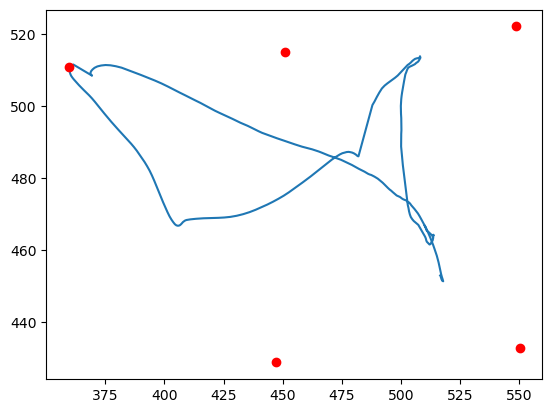

In [ ]:
# new = join_curves(a_curve1, a_curve2,cut = True)
plt.plot([item[0] for item in new], [item[1] for item in new])
# plt.plot([item[0] for item in a_curve2], [item[1] for item in a_curve2])
# plt.plot([item[0] for item in a_curve3], [item[1] for item in a_curve3])
# plt.plot([item[0] for item in a_curve4], [item[1] for item in a_curve4])

for port in port_centroids:
    plt.plot(port[0], port[1], 'o', color='red')

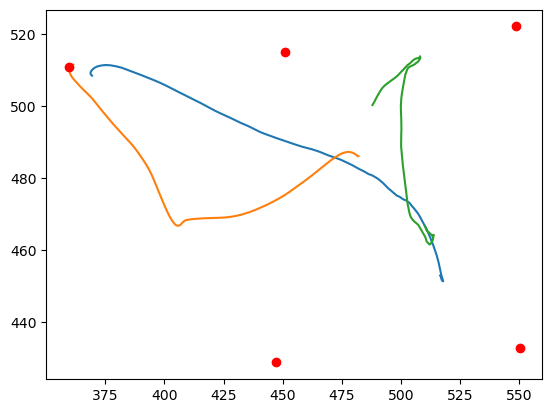

In [120]:
plt.plot([item[0] for item in a_curve1], [item[1] for item in a_curve1])
plt.plot([item[0] for item in a_curve2], [item[1] for item in a_curve2])
plt.plot([item[0] for item in a_curve3], [item[1] for item in a_curve3])
# plt.plot([item[0] for item in a_curve4], [item[1] for item in a_curve4])

for port in port_centroids:
    plt.plot(port[0], port[1], 'o', color='red')

In [79]:
complete_average

[]

In [ ]:
    start_port,end_port = 5,2
    T1_start_ind, T1_end_ind = extract_port_to_port_trajetories(start_port,end_port,frame_filter,threshold_breaks,4,-1,-1)
    start_port,end_port = 2,3
    T2_start_ind, T2_end_ind = extract_port_to_port_trajetories(start_port,end_port,frame_filter,threshold_breaks,1,4,5)
    start_port,end_port = 3,4
    T3_start_ind, T3_end_ind = extract_port_to_port_trajetories(start_port,end_port,frame_filter,threshold_breaks,1,2,5)
    start_port,end_port = 4,5
    T4_start_ind, T4_end_ind = extract_port_to_port_trajetories(start_port,end_port,frame_filter,threshold_breaks,1,2,3)
    
    # add alteration for this mouse as it messes up 
    if mouse == 'seq006_1_5':
        T3_start_ind, T3_end_ind = extract_port_to_port_trajetories(start_port,end_port,frame_filter,threshold_breaks,2,2,2)
        start_port,end_port = 4,5
        T4_start_ind, T4_end_ind = extract_port_to_port_trajetories(start_port,end_port,frame_filter,threshold_breaks,2,2,2)

In [77]:
T4_start_ind

[6961,
 np.int64(10370),
 np.int64(10570),
 np.int64(10895),
 np.int64(12582),
 np.int64(17884),
 np.int64(22943),
 np.int64(48909),
 np.int64(52110),
 np.int64(62993),
 np.int64(84007),
 np.int64(99057),
 np.int64(99684),
 np.int64(99703),
 np.int64(99726)]

In [76]:
extract_port_to_port_trajetories(start_port,end_port,frame_filter,threshold_breaks,2,2,2)

([6961,
  np.int64(10370),
  np.int64(10570),
  np.int64(10895),
  np.int64(11709),
  np.int64(12207),
  np.int64(12582),
  np.int64(17884),
  np.int64(19182),
  np.int64(22943),
  np.int64(30701),
  np.int64(39830),
  np.int64(40350),
  np.int64(48909),
  np.int64(52110),
  np.int64(62993),
  np.int64(81021),
  np.int64(84007),
  np.int64(99057),
  np.int64(99684),
  np.int64(99703),
  np.int64(99726)],
 [np.int64(7022),
  np.int64(10396),
  np.int64(10599),
  np.int64(10913),
  np.int64(11824),
  np.int64(12237),
  np.int64(12606),
  np.int64(17903),
  np.int64(19214),
  np.int64(22966),
  np.int64(30729),
  np.int64(39881),
  np.int64(40372),
  np.int64(48936),
  np.int64(52125),
  np.int64(63017),
  np.int64(81118),
  np.int64(84020),
  np.int64(99078),
  np.int64(99698),
  np.int64(99714),
  np.int64(99741)])

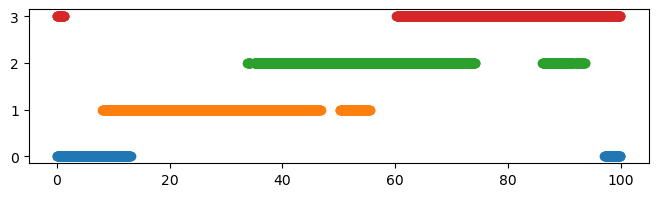

In [72]:
standard_space_path = awake_path + r'//analysis_output/reordered_recolored/fixed_standard_space//'
overlap_positions_standard_space = np.load(standard_space_path + 'overlap_positions_standard_space.npy',allow_pickle=True)

mir_row = None
for ind, row in sequence_order.iterrows():
    if row.mir in mouse:
        mir_row = row
seq_order = literal_eval(mir_row.seq_order)
continuous_regions = []
fig, ax = plt.subplots(1,1,figsize=(8, 2))
for i,seq in enumerate(seq_order):
    ax.plot(overlap_positions_standard_space[seq],np.ones(len(overlap_positions_standard_space[seq]))*i,'o')
    continuous_regions += [find_largest_continuous_region(overlap_positions_standard_space[seq])]

# create new df 
continuous_regions_df = pd.DataFrame(continuous_regions,columns=['start','end'])
continuous_regions_df['sequence'] = seq_order

In [70]:
seq

0

In [63]:
T3_start_ind, T3_end_ind = extract_port_to_port_trajetories(start_port,end_port,frame_filter,threshold_breaks,1,2,5)
start_port,end_port = 4,5
T4_start_ind, T4_end_ind = extract_port_to_port_trajetories(start_port,end_port,frame_filter,threshold_breaks,2,2,2)

In [64]:
T4_start_ind

[6532,
 np.int64(8855),
 np.int64(9072),
 np.int64(10497),
 np.int64(16096),
 np.int64(16890),
 np.int64(55394),
 np.int64(55489),
 np.int64(68509),
 np.int64(92984),
 np.int64(108328)]

In [60]:
start_port,end_port = 3,4
T3_start_ind, T3_end_ind = extract_port_to_port_trajetories(start_port,end_port,frame_filter/2,threshold_breaks,2,2,2)

In [57]:
frame_filter

125

In [61]:
T3_start_ind

[5053,
 np.int64(8833),
 np.int64(10469),
 np.int64(16863),
 np.int64(27914),
 np.int64(54279),
 np.int64(64057)]

In [ ]:
def extract_port_to_port_trajetories(start_port,end_port,frame_filter,threshold_breaks,exclude_port_1,exclude_port_2,exclude_port_3):

    start_ind = []
    end_ind = []


    index = 0
    while index < len(threshold_breaks[:-1]):
        break_ = threshold_breaks[index]
        if break_ == start_port and not threshold_breaks[index+1] ==start_port:
            # find min valin this that is larger than current - ie. next index
            p3_ind = find_next_val(index,threshold_breaks,frame_filter,end_port)
            # ignore any really bad ones that enter othe rports first, the -1 takes care of the excluded trajectories (gets rid of weird noise hwere the DLC tracking jumps outsid eof the task zone)
            if not exclude_port_1 in threshold_breaks[index:p3_ind] and not exclude_port_2 in threshold_breaks[index:p3_ind] and not exclude_port_3 in threshold_breaks[index:p3_ind] and not -1 in threshold_breaks[index:p3_ind]:
                if p3_ind != -1:
                    start_ind += [index-3]
                    end_ind += [p3_ind+3]
                    if not index == (p3_ind - 1):
                        index = p3_ind - 1
                    else:
                        index = p3_ind
                else:
                    index+=1
            else:
                index += 1
        else:
            index +=1


In [43]:
T3_start_ind

[]

In [ ]:
    a_curve1,a_curve2,a_curve3,a_curve4 = find_average_curves(port_centroids,T1_start_ind,T1_end_ind,T2_start_ind,T2_end_ind,T3_start_ind,T3_end_ind,T4_start_ind,T4_end_ind,current_x,current_y,buffer = 10, radius = 45)


In [41]:
T3_start_ind

[]

In [10]:
threshold_breaks,port_centroids,current_x,current_y,radius_used = find_task_relevant_tracking_points(back_head_centre_df[task_mask],p1[task_mask],p2[task_mask],p3[task_mask],p4[task_mask],p5[task_mask],radius = 45)

C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_18032\4028470998.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  threshold_breaks,port_centroids,current_x,current_y,radius_used = find_task_relevant_tracking_points(back_head_centre_df[task_mask],p1[task_mask],p2[task_mask],p3[task_mask],p4[task_mask],p5[task_mask],radius = 45)


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [28]:
p1[task_mask]

C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_18032\2060115564.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p1[task_mask]


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [27]:
back_head_centre_df[task_mask]

coords,x,y,likelihood,interped_x,interped_y
315838,309.613939,572.820325,0.002423,309.613939,572.820325
315839,309.613925,572.820132,0.002583,309.613925,572.820132
315840,309.613910,572.819940,0.003888,309.613910,572.819940
315841,309.613896,572.819747,0.002390,309.613896,572.819747
315842,309.613882,572.819554,0.002470,309.613882,572.819554
...,...,...,...,...,...
440440,175.653837,600.759249,0.076640,175.653837,600.759249
440441,175.531193,600.542340,0.083900,175.531193,600.542340
440442,175.408548,600.325430,0.084306,175.408548,600.325430
440443,175.285904,600.108520,0.072624,175.285904,600.108520


1

coords,x,y,likelihood,interped_x,interped_y
0,804.366333,516.767883,0.999928,804.366333,516.767883
1,803.104614,516.789368,0.999961,803.104614,516.789368
2,798.812134,517.914001,0.999803,798.812134,517.914001
3,794.026062,521.746704,0.999606,794.026062,521.746704
4,790.103149,525.221924,0.999905,790.103149,525.221924
...,...,...,...,...,...
828196,0.000000,0.000000,0.839079,0.000000,0.000000
828197,0.000000,0.000000,0.812882,0.000000,0.000000
828198,0.000000,0.000000,0.822000,0.000000,0.000000
828199,0.000000,0.000000,0.857012,0.000000,0.000000


In [25]:
camera_timestamps_df

,Unnamed: 0,Time Stamps,Trigger State,epoch
0,0,0.000000,0.0,presleep
1,1,0.016750,0.0,presleep
2,2,0.033375,0.0,presleep
3,3,0.050000,0.0,presleep
4,4,0.066625,0.0,presleep
...,...,...,...,...
828196,828196,13804.477000,0.0,postsleep
828197,828197,13804.493750,0.0,postsleep
828198,828198,13804.510375,0.0,postsleep
828199,828199,13804.527000,0.0,postsleep


In [ ]:
port_centroids,T1_start_ind,T1_end_ind,T2_start_ind,T2_end_ind,T3_start_ind,T3_end_ind,T4_start_ind,T4_end_ind,current_x,current_y,buffer = 10, radius = 45

In [94]:
T1_start_ind

[]

In [95]:
T1_end_ind

[]

In [87]:
    if 'epoch' in list(camera_timestamps_df):
        task_mask = camera_timestamps_df.epoch == 'task'

        # find task relevant tracking periods, extract times mouse is close to each behavioural port
        threshold_breaks,port_centroids,current_x,current_y,radius_used = find_task_relevant_tracking_points(back_head_centre_df[task_mask],p1[task_mask],p2[task_mask],p3[task_mask],p4[task_mask],p5[task_mask],radius = 45)
    else:
        # find task relevant tracking periods, extract times mouse is close to each behavioural port
        threshold_breaks,port_centroids,current_x,current_y,radius_used = find_task_relevant_tracking_points(back_head_centre_df,p1,p2,p3,p4,p5,radius = 45) 


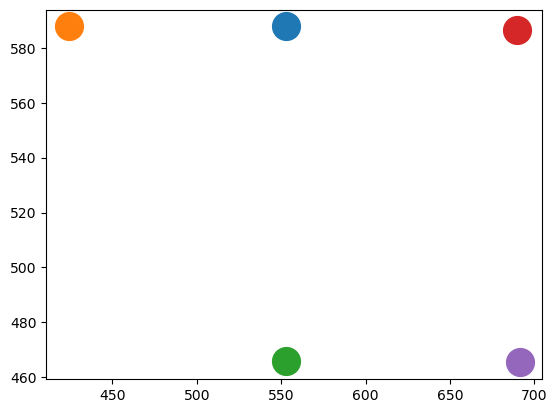

In [91]:
for i,port in enumerate(port_centroids):
    plt.plot(port[0], port[1], 'o', markersize=20, label = i)
# plt.legend()

In [90]:
port_centroids

[[np.float64(552.9498901367188), np.float64(587.75732421875)],
 [np.float64(424.1770324707031), np.float64(587.75732421875)],
 [np.float64(552.9498901367188), np.float64(465.9344177246094)],
 [np.float64(689.61865234375), np.float64(586.5291748046875)],
 [np.float64(691.340576171875), np.float64(465.4096145629883)]]

In [50]:
# # def process_and_validate_trajectories(tracking, matches, template,add_amount,frame_filter,dist_filter,num_points):
#     """
#     Process each trajectory by extending, trimming, and validating.

#     Parameters:
#         tracking: Nx2 array of (x, y) points.
#         matches: List of (start, end) indices of matching segments.
#         template: Mx2 array of template (x, y) points.
#         frame_filter: Maximum allowed length for a trajectory.

#     Returns:
#         List of processed (start, end) indices for valid trajectories.
#     """
tracking = full_tracking_coords 
matches = similar_segments
template = points
add_amount = add_start_end
frame_filter = int(time_filter / (1/fps))
dist_filter = dist_filter
num_points = num_points

processed_trajectories = []

# Define the start and end points from the template
start_centroid = template[0]
end_centroid = template[-1]

for start, end in matches:
    # Step 1: Extend the trajectory
    start = start - add_amount
    end = end + add_amount
    if start < 0:
        start = 0
    extended_trajectory = tracking[start:end]
    # Step 2: Find closest points to the start and end centroids in teh first and l;ast 30% of the trajectory
    closest_start_indices,start_distances = find_closest_to_centroid(extended_trajectory[0:int(abs(len(extended_trajectory)*0.3))], start_centroid, num_points)
    closest_end_indices,end_distances = find_closest_to_centroid(extended_trajectory[int(abs(len(extended_trajectory)*0.6))::], end_centroid, num_points)
    
    # if closest is too far away then skip
    if start_distances[np.min(closest_start_indices)] > dist_filter:
        continue
    if end_distances[np.max(closest_end_indices)] > dist_filter:
        continue
    
    # Step 3: Trim the trajectory
    trimmed_start = start + np.min(closest_start_indices)
    trimmed_end =start + int(abs(len(extended_trajectory)*0.6)) + np.max(closest_end_indices)

    
    # Step 4: Validate length
    if (trimmed_end-trimmed_start) > frame_filter:
        continue  # Skip trajectories longer than frame_filter
    
    # step 5, Add valid trajectory indices to the final list
    processed_trajectories.append([trimmed_start,trimmed_end])

  

In [46]:
tracking[start::]

[[np.float64(0.0), np.float64(0.0)],
 [np.float64(0.0), np.float64(0.0)],
 [np.float64(0.0), np.float64(0.0)],
 [np.float64(0.0), np.float64(0.0)],
 [np.float64(0.0), np.float64(0.0)]]

In [49]:
tracking[-400::]

[[np.float64(1080.6893827968092), np.float64(855.965650018032)],
 [np.float64(1080.854684072318), np.float64(856.0393329786725)],
 [np.float64(1081.0199853478266), np.float64(856.1130159393132)],
 [np.float64(1081.1852866233353), np.float64(856.1866988999539)],
 [np.float64(1081.350587898844), np.float64(856.2603818605944)],
 [np.float64(1081.5158891743527), np.float64(856.334064821235)],
 [np.float64(1081.6811904498613), np.float64(856.4077477818757)],
 [np.float64(1081.84649172537), np.float64(856.4814307425163)],
 [np.float64(1082.0117930008787), np.float64(856.5551137031568)],
 [np.float64(1082.1770942763874), np.float64(856.6287966637975)],
 [np.float64(1082.342395551896), np.float64(856.7024796244382)],
 [np.float64(1082.5076968274047), np.float64(856.7761625850787)],
 [np.float64(1082.6729981029134), np.float64(856.8498455457194)],
 [np.float64(1082.838299378422), np.float64(856.9235285063601)],
 [np.float64(1083.0036006539308), np.float64(856.9972114670006)],
 [np.float64(1083.

In [42]:
extended_trajectory[0:int(abs(len(extended_trajectory)*0.3))]

# start_centroid



# num_points

[]

In [43]:
extended_trajectory

[]

In [ ]:
# def find_closest_to_centroid(tracking_, centroid, num_points=100):


distances = distance.cdist(tracking_, [centroid], metric='euclidean').flatten()
closest_indices = np.argsort(distances)[:num_points]

In [40]:
add_amount

5

In [39]:
end

57

In [36]:
valid_trajectories = process_and_validate_trajectories(full_tracking_coords, similar_segments, points,add_start_end,int(time_filter / (1/fps)),dist_filter,num_points)


ValueError: XA must be a 2-dimensional array.

In [10]:
list(all_mice_dict)

['136_1_3',
 '136_1_4',
 '148_2_2',
 '149_1_1',
 '178_1_4',
 '178_1_5',
 '178_1_6',
 '178_1_7',
 '178_1_8',
 '178_1_9',
 '178_2_1',
 '178_2_2',
 '178_2_4',
 '269_1_1',
 '269_1_3',
 '269_1_4',
 '269_1_7',
 '270_1_3',
 '270_1_5',
 '270_1_6',
 'seq006_1_11',
 '268_1_2',
 '269_1_2',
 '270_1_1',
 'ap5R_1_1',
 'ap5R_1_3',
 'seq006_1_1',
 'seq006_1_4',
 'seq006_1_5',
 'seq006_1_6',
 'seq007_1_1',
 'seq007_1_2',
 'seq007_1_3',
 'ap5R_1_2',
 'seq006_1_10',
 'seq006_1_3',
 'seq006_1_8',
 'seq006_1_9']